<a href="https://colab.research.google.com/github/williiiamr/Weather-Prediction/blob/master/Collab/Weather_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf

In [ ]:
df = pd.read_excel('/content/cuaca_fix.xlsx', dtype={'Tanggal':str} , parse_dates=False)
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df.set_index('Tanggal', inplace=True)
columns = ['MAX_TEMP', 'MIN_TEMP', 'SUNLIGHT', 'AVG_HUM', 'MAX_WINDSPEED', 'WINDIR']
df = df.drop(columns = columns)

In [ ]:
df.head()

,AVG_TEMP,RAINFALL,AVG_WINDSPEED
Tanggal,,,
2020-01-01,27.05,36.5,6.4
2020-01-02,27.90,0.0,5.8
2020-01-03,28.50,0.0,6.2
2020-01-04,29.05,0.0,7.9
2020-01-05,27.95,0.0,6.6


# Check Missing Values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2020-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AVG_TEMP       1456 non-null   float64
 1   RAINFALL       1457 non-null   float64
 2   AVG_WINDSPEED  1456 non-null   float64
dtypes: float64(3)
memory usage: 45.7 KB


In [ ]:
df.isna().sum()

AVG_TEMP         5
RAINFALL         4
AVG_WINDSPEED    5
dtype: int64

In [ ]:
df.fillna(round(df.rolling(window=7, min_periods=1).mean(), 2), inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2020-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AVG_TEMP       1461 non-null   float64
 1   RAINFALL       1461 non-null   float64
 2   AVG_WINDSPEED  1461 non-null   float64
dtypes: float64(3)
memory usage: 45.7 KB


# Feature Selection

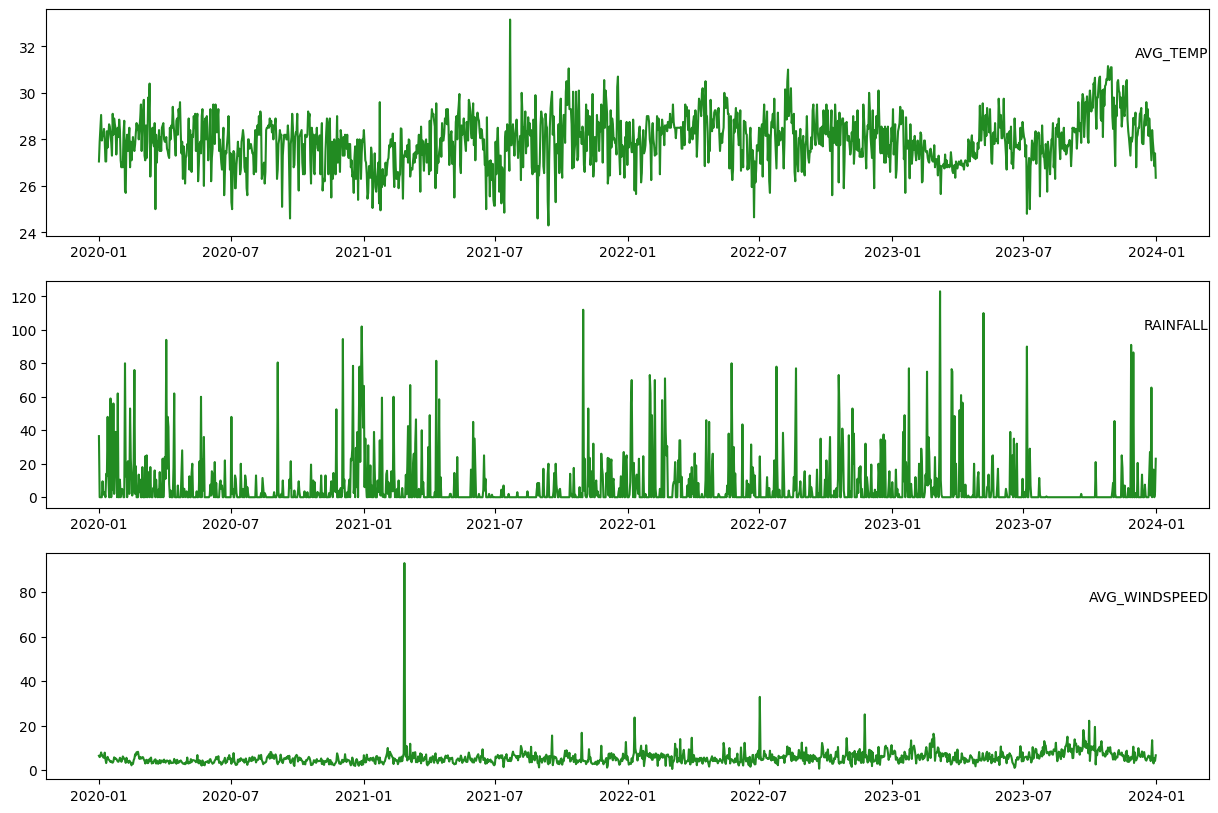

In [ ]:
i = 1
plt.figure(figsize=(15,10))
for column in df.columns:
  plt.subplot(len(df.columns), 1, i)
  plt.plot(df[column], c = "forestgreen")
  plt.title(column, y=0.75, loc='right', fontsize = 10)
  i += 1
plt.show()

## Splitting Dataset

In [ ]:
length = round(len(df) * 0.8)
train = df[:length]
test = df[length:]

print(f'Length of Training Data: {len(train)}')
print(f'Length of Test Data: {len(test)}')

Length of Training Data: 1169
Length of Test Data: 292


In [ ]:
train

,AVG_TEMP,RAINFALL,AVG_WINDSPEED
Tanggal,,,
2020-01-01,27.05,36.5,6.40
2020-01-02,27.90,0.0,5.80
2020-01-03,28.50,0.0,6.20
2020-01-04,29.05,0.0,7.90
2020-01-05,27.95,0.0,6.60
...,...,...,...
2023-03-10,26.85,1.5,7.16
2023-03-11,26.85,0.0,7.50
2023-03-12,26.85,0.0,6.13


In [ ]:
test

,AVG_TEMP,RAINFALL,AVG_WINDSPEED
Tanggal,,,
2023-03-15,27.35,0.0,7.630000
2023-03-16,26.80,0.0,5.906667
2023-03-17,27.10,0.0,7.563333
2023-03-18,26.80,0.0,3.596667
2023-03-19,26.90,0.0,5.083333
...,...,...,...
2023-12-27,27.90,6.5,4.388889
2023-12-28,27.50,16.5,2.944444
2023-12-29,26.85,0.0,5.438272


In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

## Alternative way to window dataset

In [ ]:
length = 7
batch_size = 32
generator = TimeseriesGenerator(train_scaled, train_scaled,
                                length=length,
                                batch_size=batch_size,
                                shuffle=False)

In [ ]:
len(train_scaled)

1169

In [ ]:
len(generator)

37

In [ ]:
X,y = generator[0]
X.shape

(32, 7, 3)

In [ ]:
validation_generator = TimeseriesGenerator(test_scaled,test_scaled,
                                           length=length, batch_size=16, shuffle=False)

In [ ]:
len(validation_generator)

18

In [ ]:
X,y = validation_generator[0]
X.shape

(16, 7, 3)

##Running Model

In [ ]:
# from tensorflow.keras.models import load_model

# # Load the model
# model = load_model('/content/modelGRU128new.h5')

In [ ]:
n_steps = 7
n_features = train_scaled.shape[1]

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, activation='relu', input_shape=(n_steps,n_features), return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_features)
])


In [ ]:
lr = 0.0001
loss = tf.keras.losses.Huber()
optimizer = tf.keras.optimizers.Adam(lr=lr)

model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
history = model.fit(generator, validation_data=validation_generator,
                    epochs=100)

Epoch 1/100
37/37 [==============================] - 3s 24ms/step - loss: 0.0083 - mae: 0.0861 - val_loss: 0.0048 - val_mae: 0.0557
Epoch 2/100
37/37 [==============================] - 1s 14ms/step - loss: 0.0061 - mae: 0.0731 - val_loss: 0.0047 - val_mae: 0.0648
Epoch 3/100
37/37 [==============================] - 1s 15ms/step - loss: 0.0058 - mae: 0.0697 - val_loss: 0.0045 - val_mae: 0.0628
Epoch 4/100
37/37 [==============================] - 1s 14ms/step - loss: 0.0055 - mae: 0.0675 - val_loss: 0.0046 - val_mae: 0.0569
Epoch 5/100
37/37 [==============================] - 1s 15ms/step - loss: 0.0056 - mae: 0.0681 - val_loss: 0.0044 - val_mae: 0.0563
Epoch 6/100
37/37 [==============================] - 2s 41ms/step - loss: 0.0054 - mae: 0.0661 - val_loss: 0.0045 - val_mae: 0.0542
Epoch 7/100
37/37 [==============================] - 2s 45ms/step - loss: 0.0055 - mae: 0.0668 - val_loss: 0.0048 - val_mae: 0.0643
Epoch 8/100
37/37 [==============================] - 1s 14ms/step - loss: 0.

In [ ]:
model.save('modelGRU6496.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


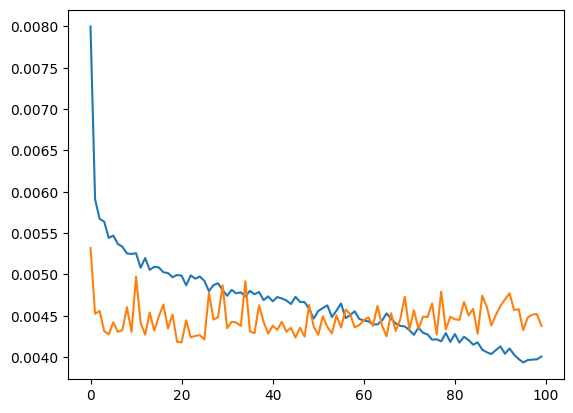

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

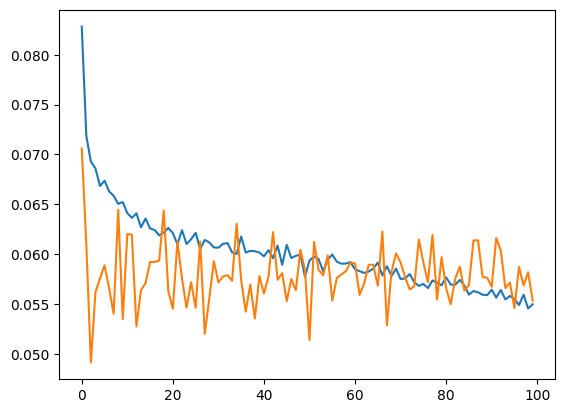

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.show()

##Save Model

## Forecasting on test data

In [ ]:
import math
def round_decimal(lists):
  new_list = []
  for i in lists:
    if i < 0:
      i = 0
    else:
      i = math.floor(i*100)/100
    new_list.append(i)

  return new_list

In [ ]:
y_hat = model.predict(validation_generator)

18/18 [==============================] - 0s 4ms/step


In [ ]:
y_hat = scaler.inverse_transform(y_hat)
inv_yhat = np.array(list(map(round_decimal, y_hat)))

In [ ]:
y_true = test[length:]

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
for idx, i in enumerate(test.columns):
  mse = mean_squared_error(y_true.loc[:, [f'{i}']], inv_yhat[:, idx])
  mae = mean_absolute_error(y_true.loc[:, [f'{i}']], inv_yhat[:, idx])
  rmse = sqrt(mse)
  print(f'RMSE for column {idx + 1}: %f' % rmse)
  print(f'MAE for column {idx + 1}: %f \n' % mae)

RMSE for column 1: 0.802591
MAE for column 1: 0.642254 

RMSE for column 2: 16.020069
MAE for column 2: 8.706596 

RMSE for column 3: 2.931821
MAE for column 3: 2.063371 



In [ ]:
mse = mean_squared_error(y_true, inv_yhat)
rmse = sqrt(mse)
print(f'RMSE for the whole column: %f' % rmse)

RMSE for the whole column: 9.414215


In [ ]:
mae = mean_absolute_error(y_true, inv_yhat)
print(f'MAE for the whole column: %f' % mae)

MAE for the whole column: 3.804074


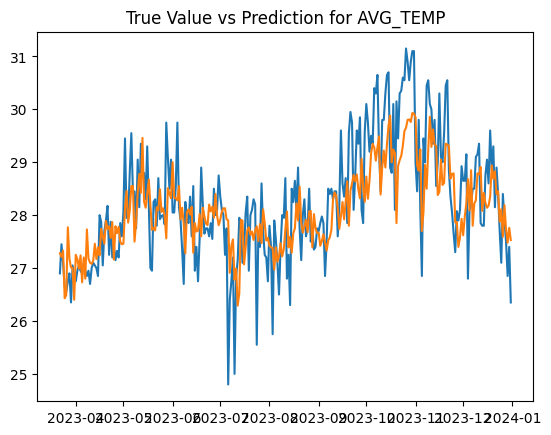

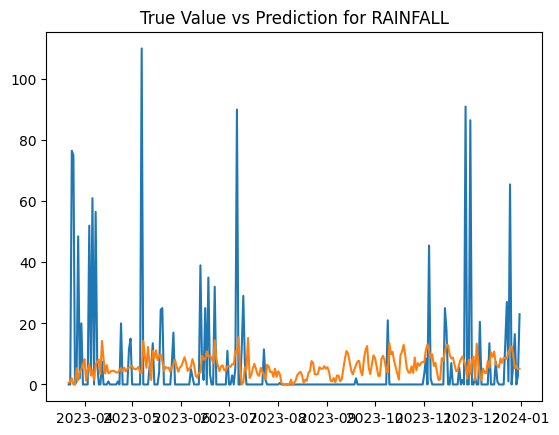

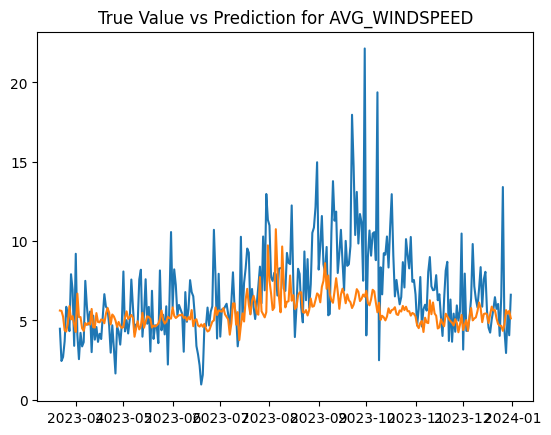

In [ ]:
variables_to_plot = list(train.columns)
for variable in variables_to_plot:
    test_variable = y_true.loc[:, [variable]]
    test_variable['y_pred'] = inv_yhat[:, variables_to_plot.index(variable)]

    plt.plot(test_variable)
    plt.title(f'True Value vs Prediction for {variable}')
    plt.show()